## Learning Data Augmentation

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torchvision

import datasets
import autoencoder
import cnn
import vae
import utils

torch.cuda.set_device(0) # or 1

## Dataset

In [ ]:
trn_dset, tst_dset = datasets.get_mnist_dataset(trn_size=60000, tst_size=10000)
trn_loader, tst_loader = datasets.get_cifar_loader(trn_dset, tst_dset, batch_size=128)
inputs,targets = next(iter(trn_loader))
inputs.size()

In [ ]:
utils.plot_batch(inputs[:32])
print("Train:", len(trn_loader.dataset), "Test:", len(tst_loader.dataset), 
      "Input:", inputs.size(), "Target:", targets.size())

## Classifier

In [ ]:
model = cnn.CNN(in_shape=(1,28,28), n_classes=10).cuda()

In [ ]:
epochs = 10
iters = epochs * len(trn_loader)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
lr_adjuster = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
trainer = cnn.Trainer(optimizer, lr_adjuster)

In [ ]:
trainer.run(model, trn_loader, tst_loader, criterion, epochs)

In [ ]:
utils.plot_metric(trainer.metrics['loss']['trn'], trainer.metrics['loss']['tst'], 'Loss')
utils.plot_metric(trainer.metrics['accuracy']['trn'], trainer.metrics['accuracy']['tst'], 'Accuracy')

## VAE

In [109]:
model = vae.VAE(in_shape=(1,28,28), n_latent=100).cuda()

In [110]:
criterion = nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

Epoch 1, TrnLoss: 4322.3505, TstLoss: 925.1661


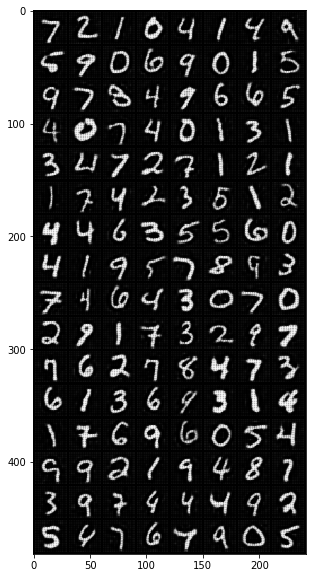

Epoch 2, TrnLoss: 649.8581, TstLoss: 504.1390
Epoch 3, TrnLoss: 474.0854, TstLoss: 439.6261
Epoch 4, TrnLoss: 430.6088, TstLoss: 419.8127
Epoch 5, TrnLoss: 410.7674, TstLoss: 396.7804
Epoch 6, TrnLoss: 397.3060, TstLoss: 386.1212


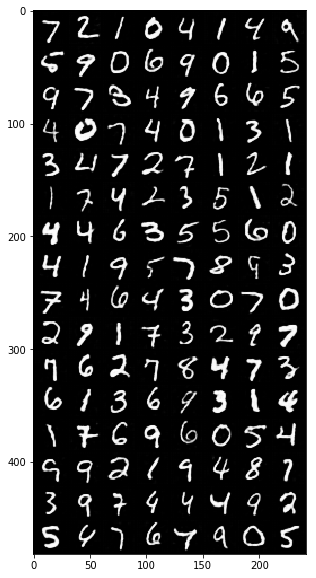

Epoch 7, TrnLoss: 388.8606, TstLoss: 387.0583
Epoch 8, TrnLoss: 381.0688, TstLoss: 374.8765
Epoch 9, TrnLoss: 374.6519, TstLoss: 369.8904
Epoch 10, TrnLoss: 370.0834, TstLoss: 363.1534


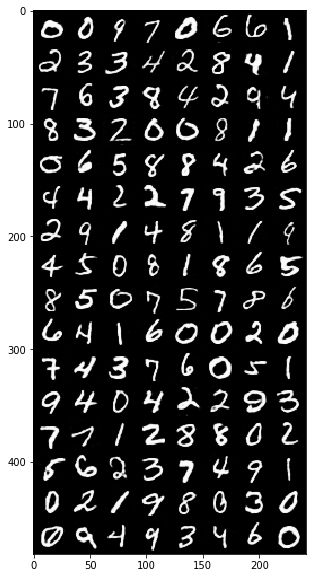

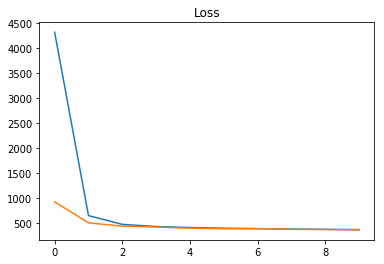

In [111]:
losses = vae.run(model, trn_loader, tst_loader, criterion, 
                 optimizer, epochs=10, plot_interval=5)
utils.plot_metric(losses['trn'], losses['tst'], 'Loss')

In [112]:
# Single Image
img_idx = 1
noise = 1. + torch.randn(1) * 1e-1 
inputs,targs=next(iter(tst_loader))
recon, mean, var = vae.predict(model, inputs[img_idx])
out = vae.generate(model, mean*noise, var*noise)

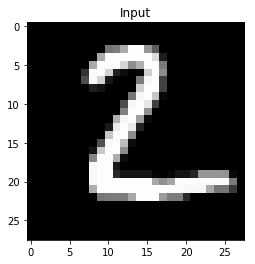

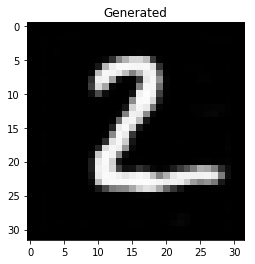

In [113]:
utils.plot_batch(inputs[img_idx], title="Input", fs=(4,4)) 
utils.plot_batch(out, title="Generated", fs=(4,4))

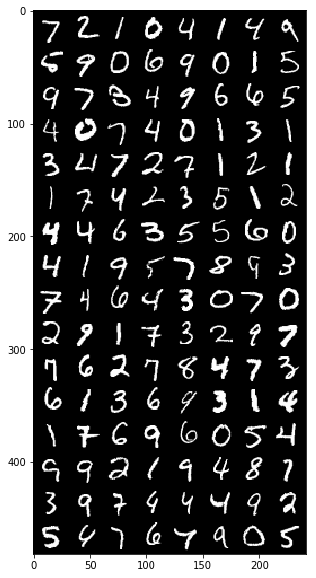

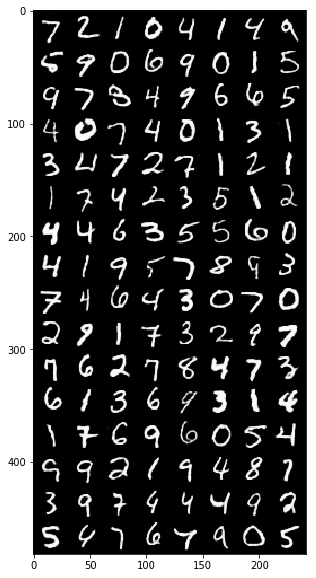

In [114]:
# Batch
recon, mean, var = vae.predict(model, inputs)
out = vae.generate(model, mean, var)
utils.plot_batch(inputs)
utils.plot_batch(out)

## Classifier w VAE Augmentation

In [115]:
augmentor = model
classifier = cnn.CNN(in_shape=(1,28,28), n_classes=10).cuda()

In [116]:
epochs = 10
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_adjuster = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
trainer = cnn.Trainer(optimizer, lr_adjuster, augmentor)

In [117]:
trainer.run(classifier, trn_loader, tst_loader, criterion, epochs)

Epoch 1, TrnLoss: 1.573, TrnAcc: 0.955, TstLoss: 1.478, TstAcc: 0.989
Epoch 2, TrnLoss: 1.480, TrnAcc: 0.989, TstLoss: 1.472, TstAcc: 0.991
Epoch 3, TrnLoss: 1.475, TrnAcc: 0.992, TstLoss: 1.470, TstAcc: 0.993
Epoch 4, TrnLoss: 1.470, TrnAcc: 0.995, TstLoss: 1.469, TstAcc: 0.994
Epoch 5, TrnLoss: 1.469, TrnAcc: 0.995, TstLoss: 1.469, TstAcc: 0.994
Epoch 6, TrnLoss: 1.468, TrnAcc: 0.996, TstLoss: 1.468, TstAcc: 0.994
Epoch 7, TrnLoss: 1.467, TrnAcc: 0.997, TstLoss: 1.469, TstAcc: 0.994
Epoch 8, TrnLoss: 1.467, TrnAcc: 0.997, TstLoss: 1.468, TstAcc: 0.994
Epoch 9, TrnLoss: 1.466, TrnAcc: 0.997, TstLoss: 1.468, TstAcc: 0.994
Epoch 10, TrnLoss: 1.466, TrnAcc: 0.997, TstLoss: 1.468, TstAcc: 0.994


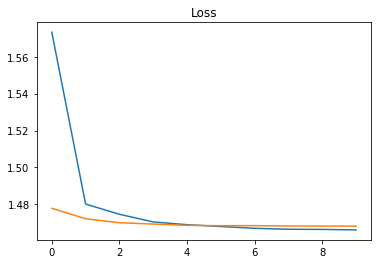

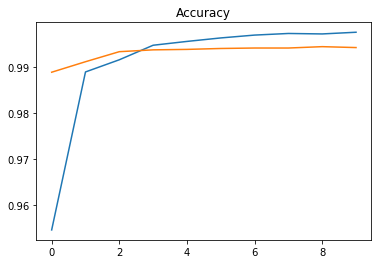

In [118]:
utils.plot_metric(trainer.metrics['loss']['trn'], trainer.metrics['loss']['tst'], 'Loss')
utils.plot_metric(trainer.metrics['accuracy']['trn'], trainer.metrics['accuracy']['tst'], 'Accuracy')

## GAN

In [ ]:
# https://arxiv.org/abs/1711.04340